### Importation des données

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
import yaml
import importlib
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import xgboost as xgb

import dataprocessing
import utils

In [16]:
importlib.reload(utils)
importlib.reload(dataprocessing)

<module 'dataprocessing' from '/home/alexandre-tonon/SDD/Hackathons/Hackathon_Heart_Rate_Los_Tigros/dataprocessing.py'>

In [17]:
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")

### Data Processing

In [18]:
def data_processing(
    df: pd.DataFrame,
    test: bool = False,
    feature_info=None,            # laissé pour compatibilité (non utilisé ici)
    scaler: StandardScaler | None = None,
    config_path: str = "features.yaml",
    codebook_html: str = "data/USCODE22_LLCP_102523.HTML"
):
    """
    Mode entraînement (test=False) -> retourne (X, y, features_99, scaler)
    Mode test (test=True)         -> retourne X (transformé avec scaler fourni)
    """
    # 1) Config + codebook
    config, codebook = dataprocessing._load_config_and_codebook(config_path, codebook_html)
    features = config['features']

    # 2) Sélection colonnes
    X = df[features].copy()

    # 3) Typage features via codebook
    features_classification = dataprocessing._classify_features(codebook, features)

    # 4) Nettoyage / encodage
    X, continuous_columns = dataprocessing._clean_and_engineer(X, features_classification)

    # 5) Scaling
    if test:
        if scaler is not None:
            X[continuous_columns] = scaler.transform(X[continuous_columns])

        if feature_info is not None:
            X = X[feature_info]
            
        return X
    else:
        # y et fit scaler
        if 'TARGET' not in df.columns:
            raise ValueError("Colonne TARGET absente du DataFrame en mode entraînement.")
        y = df['TARGET'].astype(int)

        if scaler is not None:
            X[continuous_columns] = scaler.fit_transform(X[continuous_columns])

        return X, y, scaler

In [19]:
df_train_processed, y_train, scaler = data_processing(df=df_train, 
                                                      scaler=MinMaxScaler(),
                                                      test=False)

In [20]:
#top15 = ['_AGEG5YR', 'WEIGHT2', '_STATE', 'HEIGHT3', 'GENHLTH', 'PHYSHLTH', 'SLEPTIM1', 'POORHLTH', 'LCSSCNCR', 'MENTHLTH', 'PERSDOC3', 'CVDSTRK3', '_PACKDAY', 'ALCDAY4', '_SMOKGRP']
#df_train_processed = df_train_processed[top15]

In [21]:
df_train_final = df_train_processed.copy()
df_test_final = data_processing(df=df_test, 
                                scaler=scaler,
                                test=True,
                                feature_info=df_train_final.columns)

### Scoring

In [22]:
DATA_AUGMENTATION = False
X_train_train, X_val_train, y_train_split, y_val_train = train_test_split(
    df_train_final, y_train, test_size=0.2, random_state=42)

if DATA_AUGMENTATION:
    bad_health = X_train_train[y_train_split == 1]
    bad_health = bad_health[bad_health['GENHLTH'] == 5]

    print(len(X_train_train), len(bad_health))

    # Concaténation
    X_train_balanced = pd.concat([X_train_train, bad_health], ignore_index=True)
    y_train_balanced = pd.concat([y_train_split, pd.Series([1] * len(bad_health))], ignore_index=True)
else:
    X_train_balanced = X_train_train
    y_train_balanced = y_train_split

# Création des matrices XGBoost
dtrain_scoring = xgb.DMatrix(data=X_train_balanced, label=y_train_balanced)
dtest_scoring = xgb.DMatrix(data=X_val_train, label=y_val_train)

In [23]:
import optuna
def objective(trial):
    param = {
        "learning_rate": trial.suggest_float("learning_rate", 0.1, 0.35),
        "max_depth": trial.suggest_int("max_depth", 3, 20),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 50),
        "objective":'binary:logistic',
        "seed":42,
    }
    threshold = trial.suggest_float("threshold", 0.05, 0.30)
    model = xgb.train(param, dtrain_scoring, num_boost_round=trial.suggest_int("num_boost_round", 20, 200))
    preds = model.predict(dtest_scoring)
    
    pred_labels = (preds >= threshold).astype(int)
    
    f1 = f1_score(y_val_train, pred_labels)
    return f1

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200)

[I 2025-11-05 11:44:38,345] A new study created in memory with name: no-name-96ce1efb-1fb4-4e7e-ba59-475e4e2d9d3d
[I 2025-11-05 11:44:39,846] Trial 0 finished with value: 0.3617504807412156 and parameters: {'learning_rate': 0.15258540563292622, 'max_depth': 16, 'min_child_weight': 48, 'threshold': 0.0954794781280053, 'num_boost_round': 49}. Best is trial 0 with value: 0.3617504807412156.
[I 2025-11-05 11:44:41,398] Trial 1 finished with value: 0.34305795727115523 and parameters: {'learning_rate': 0.31921239303168997, 'max_depth': 14, 'min_child_weight': 27, 'threshold': 0.0753918765134053, 'num_boost_round': 93}. Best is trial 0 with value: 0.3617504807412156.
[I 2025-11-05 11:44:43,168] Trial 2 finished with value: 0.3463241322765783 and parameters: {'learning_rate': 0.3252346588970122, 'max_depth': 6, 'min_child_weight': 20, 'threshold': 0.08001970147346983, 'num_boost_round': 172}. Best is trial 0 with value: 0.3617504807412156.
[I 2025-11-05 11:44:47,507] Trial 3 finished with valu

In [1]:
params_optim = study.best_params

params ={
    'learning_rate': params_optim['learning_rate'],
    'max_depth': params_optim['max_depth'],
    'min_child_weight': params_optim['min_child_weight'],
    'objective':'binary:logistic',
    'seed':42,
}
threshold = params_optim.pop("threshold")

model_xgb = xgb.train(params, dtrain_scoring, num_boost_round=100)

predictions_val = model_xgb.predict(dtest_scoring)
predictions_val_binary = (predictions_val > threshold).astype(int)

f1_score_ = f1_score(y_val_train, predictions_val_binary)
accuracy_score_ = accuracy_score(y_val_train, predictions_val_binary)
precision_score_ = precision_score(y_val_train, predictions_val_binary)
recall_score_ = recall_score(y_val_train, predictions_val_binary)

print("F1 Score (Validation):", f1_score_)
print("Accuracy Score (Validation):", accuracy_score_)
print("Precision Score (Validation):", precision_score_)
print("Recall Score (Validation):", recall_score_)

NameError: name 'study' is not defined

In [ ]:
if DATA_AUGMENTATION:
    bad_health = df_train_final[y_train == 1]
    bad_health = bad_health[bad_health['GENHLTH'] >4]

    df_train_final = pd.concat([df_train_final, bad_health], ignore_index=True)
    y_train = pd.concat([y_train, pd.Series([1] * len(bad_health))], ignore_index=True)

dtrain = xgb.DMatrix(data=df_train_final, label=y_train)
dtest = xgb.DMatrix(data=df_test_final)

best_trials = sorted(study.trials, key=lambda t: t.value, reverse=True)[:10]

for i, trial in enumerate(best_trials, 1):
    params_optim = trial.params.copy()

    params = {
        'learning_rate': params_optim['learning_rate'],
        'max_depth': params_optim['max_depth'],
        'min_child_weight': params_optim['min_child_weight'],
        'objective': 'binary:logistic',
        'seed': 42,
    }

    # pop threshold safely
    threshold = params_optim.pop("threshold", 0.5)

    model_xgb = xgb.train(params, dtrain, num_boost_round=100)

    predictions_test = model_xgb.predict(dtest)
    predictions_test_binary = (predictions_test > threshold).astype(int)

    submission = pd.DataFrame()
    submission['ID'] = df_test['ID']
    submission['TARGET'] = predictions_test_binary
    submission.to_csv("submission.csv", index=False)

    !kaggle competitions submit -c sdd-hackaton-25-heart-risk -f submission.csv -m "param :{params_optim}, f1_val: {f1_score_}"

100%|█████████████████████████████████████████| 659k/659k [00:01<00:00, 616kB/s]


/tmp/ipykernel_4761/2975885630.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


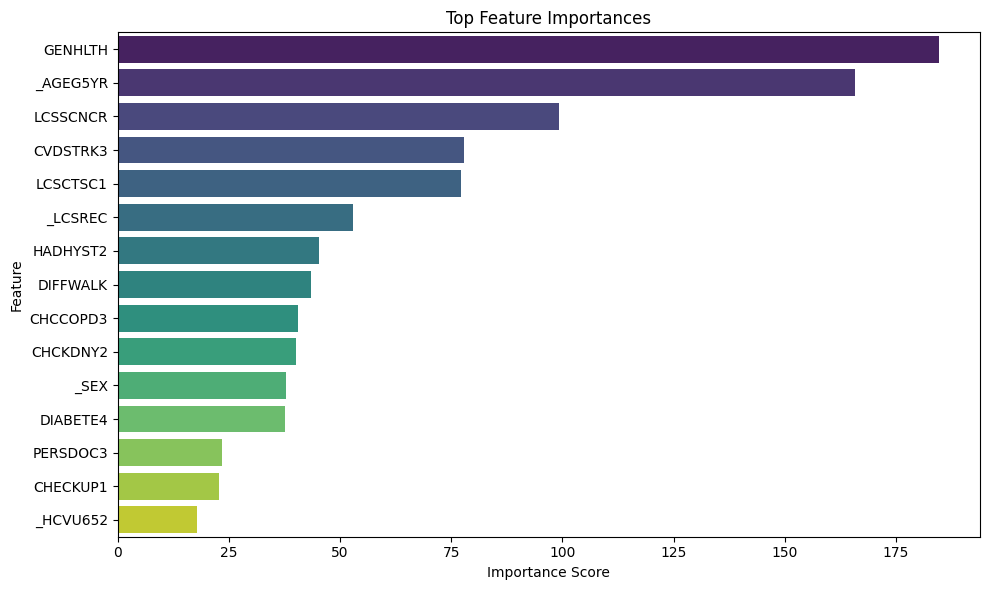

In [ ]:
def plot_feature_importance(model, feature_names, max_num_features=10):
    importance_dict = model.get_score(importance_type='gain')
    importance_df = pd.DataFrame({
        'Feature': list(importance_dict.keys()),
        'Importance': list(importance_dict.values())
    })
    importance_df = importance_df.sort_values(by='Importance', ascending=False).head(max_num_features)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
    plt.title('Top Feature Importances')
    plt.xlabel('Importance Score')
    plt.ylabel('Feature')
    plt.tight_layout()
    return importance_df

importance_df = plot_feature_importance(model_xgb, df_train_final.columns, max_num_features=15)

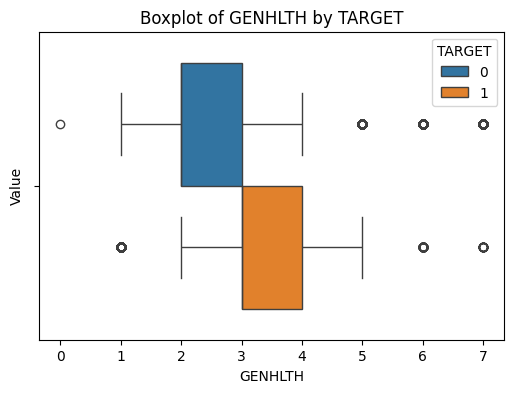

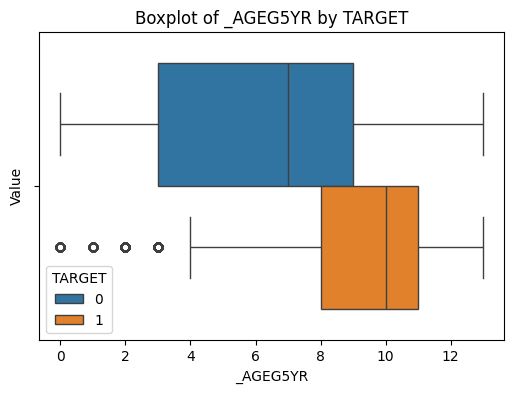

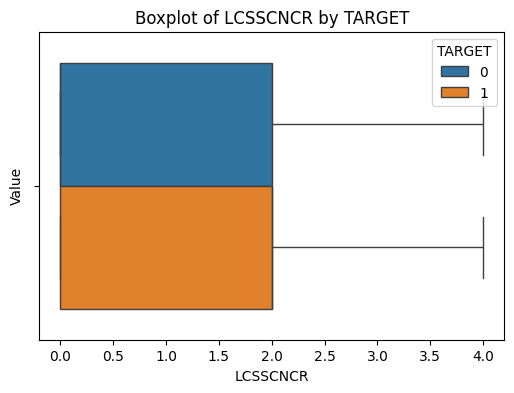

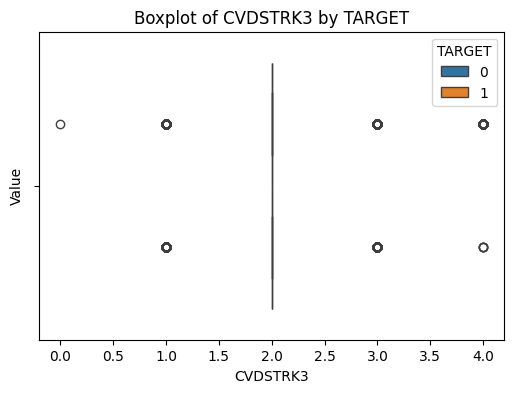

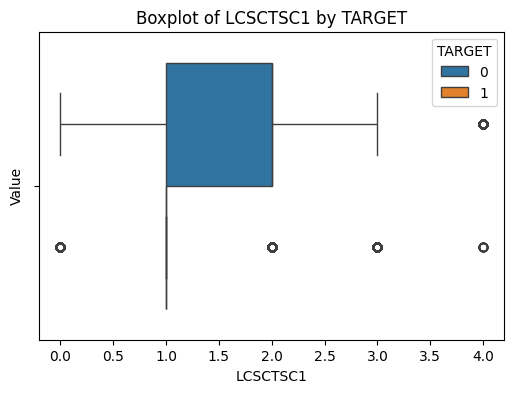

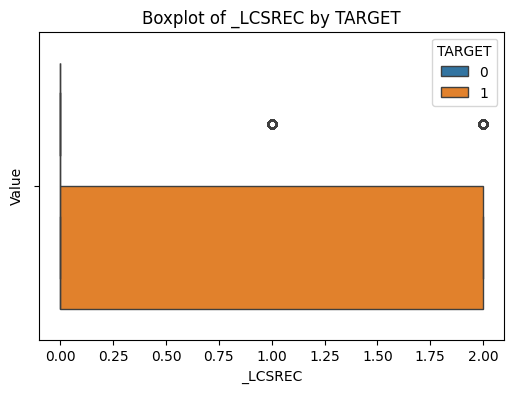

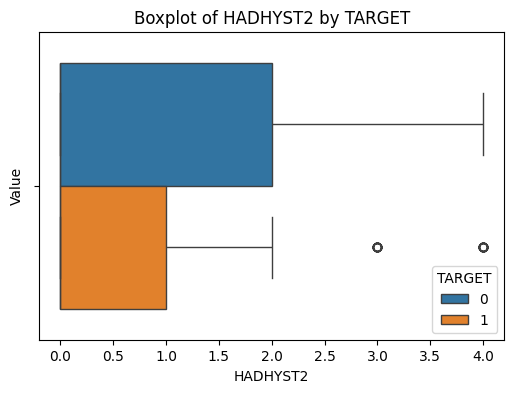

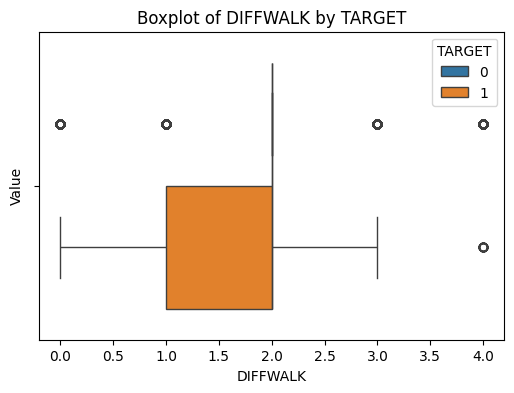

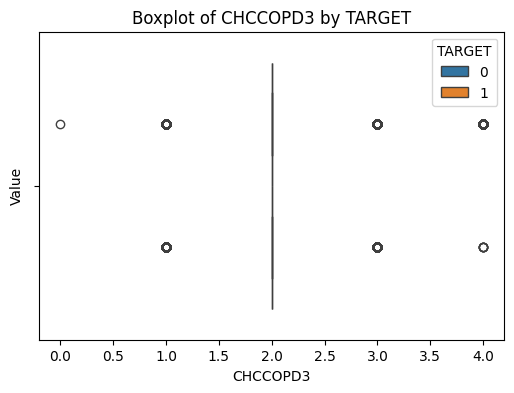

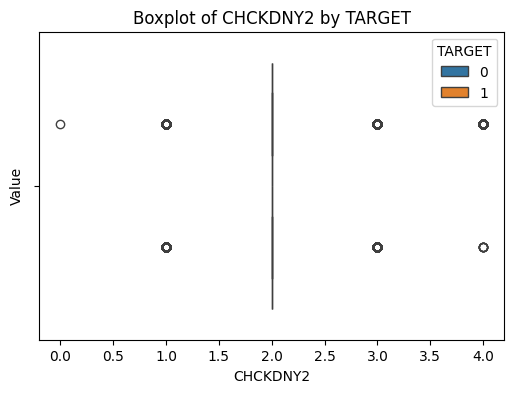

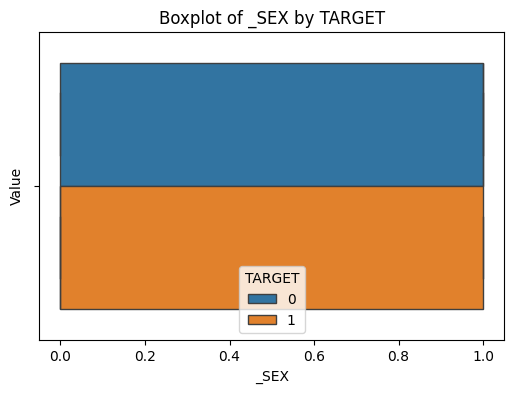

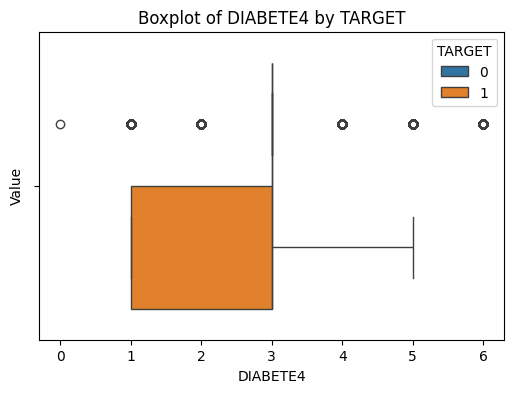

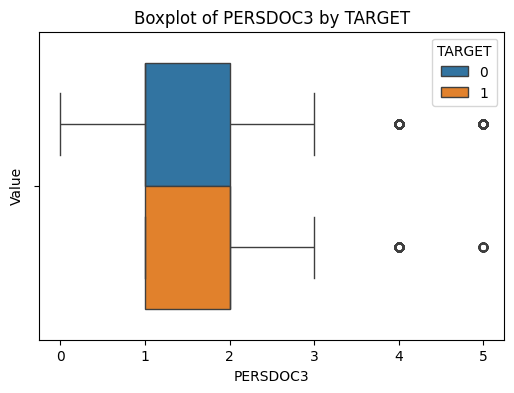

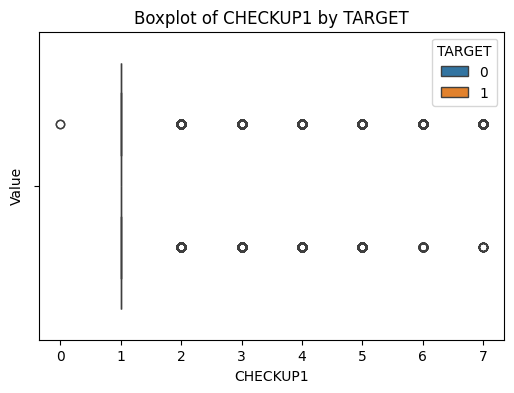

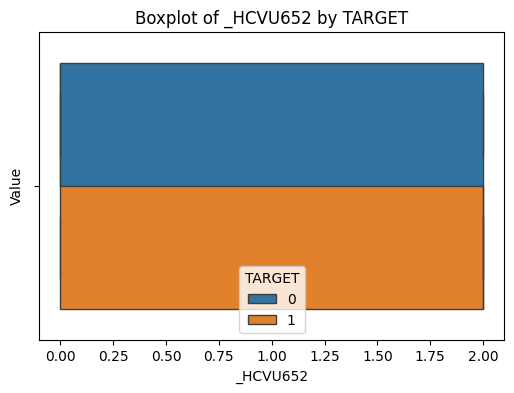

In [ ]:
feat = importance_df['Feature'].tolist()
for ft in feat:
    plt.figure(figsize=(6,4))
    sns.boxplot(data=df_train_final, x=ft, hue=y_train)
    plt.title(f'Boxplot of {ft} by TARGET')
    plt.xlabel(ft)
    plt.ylabel('Value')
    plt.show()

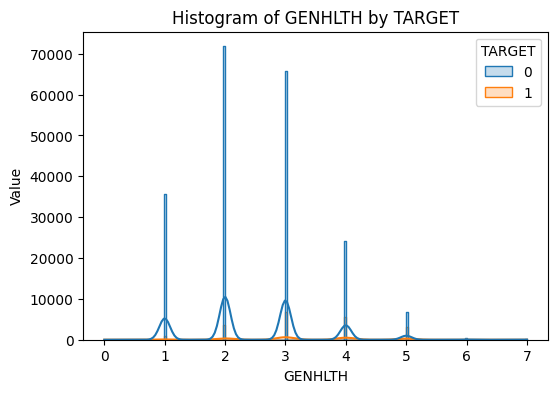

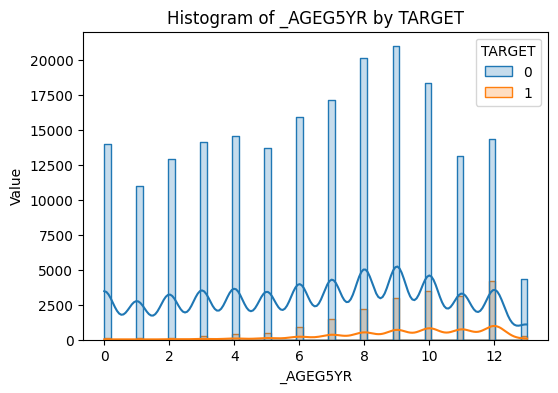

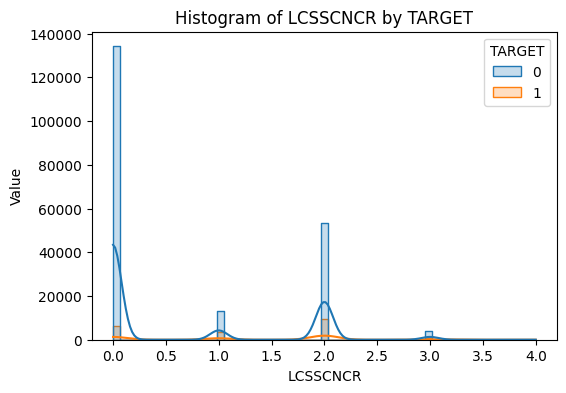

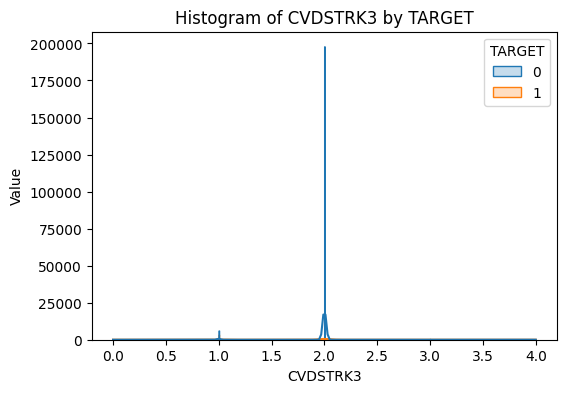

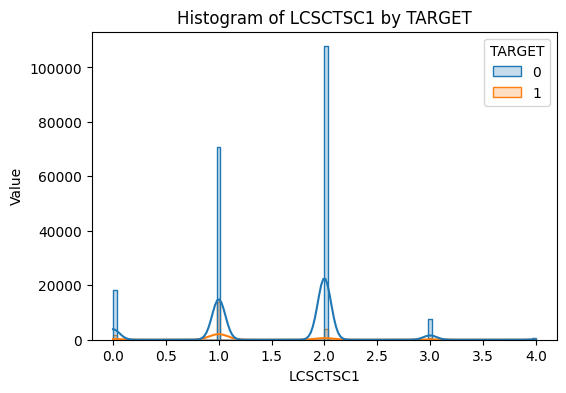

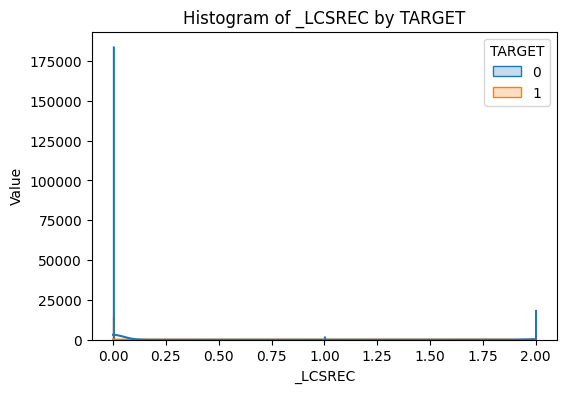

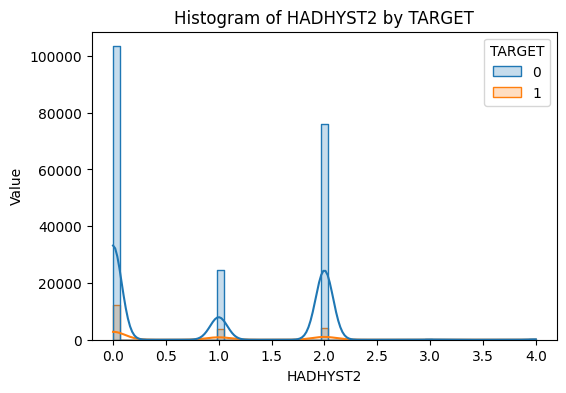

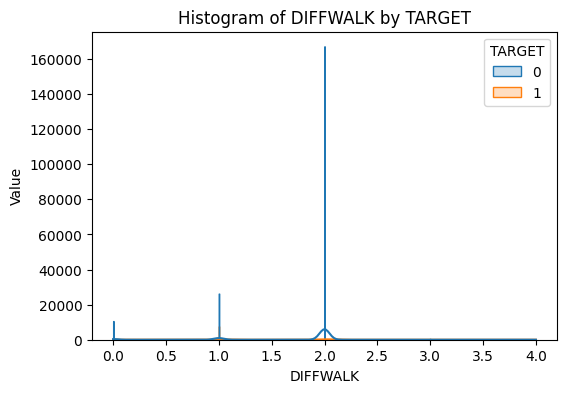

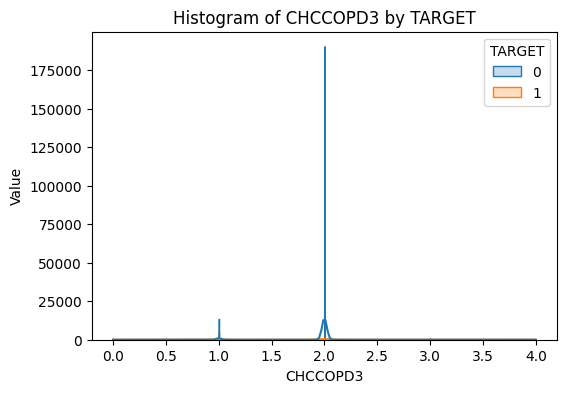

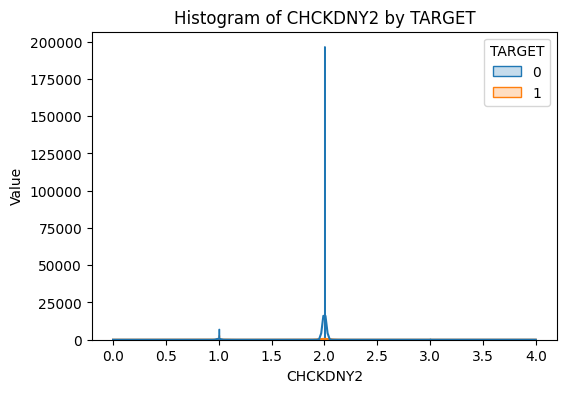

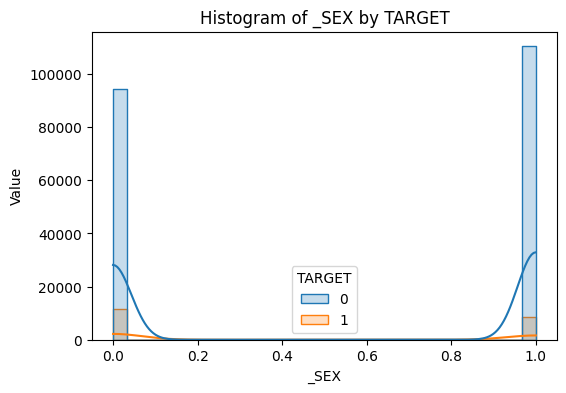

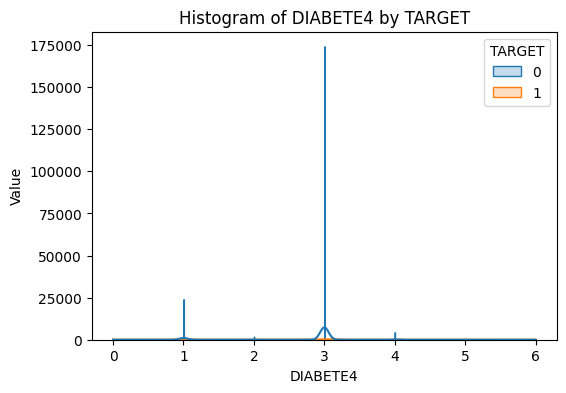

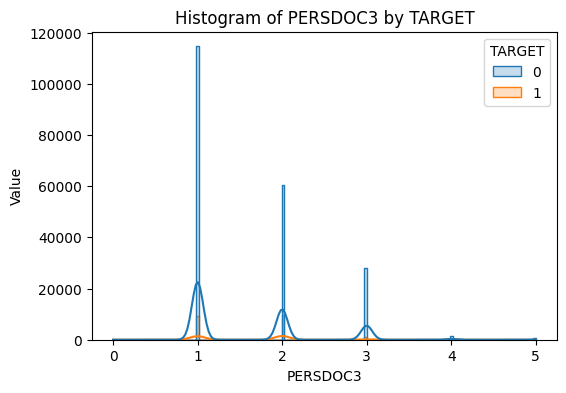

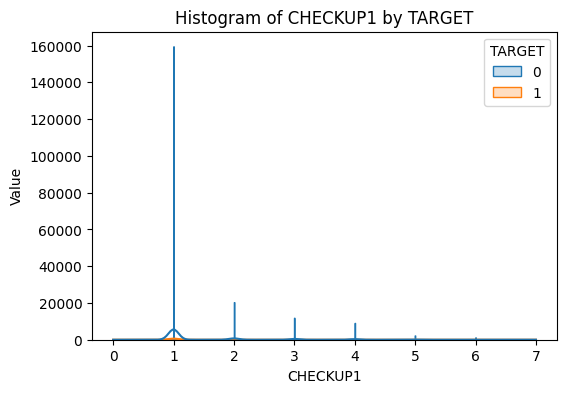

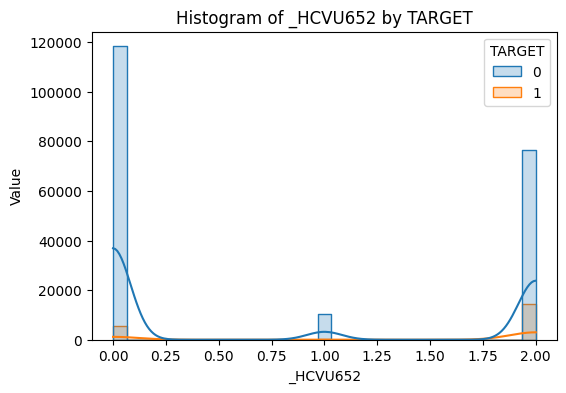

In [ ]:
feat = importance_df['Feature'].tolist()
for ft in feat:
    plt.figure(figsize=(6,4))
    sns.histplot(data=df_train_final, x=ft, hue=y_train, kde=True, element="step")
    plt.title(f'Histogram of {ft} by TARGET')
    plt.xlabel(ft)
    plt.ylabel('Value')
    plt.show()